This notebook is using Torchgeo's tutorials. For more information, you can find the tutorials on their [website](https://torchgeo.readthedocs.io/en/stable/tutorials/getting_started.html).

# Setup

Import all necessary python libraries in this section.

In [1]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from torchgeo.datasets import NAIP, ChesapeakeDE
from torchgeo.datasets.utils import download_url, stack_samples
from torchgeo.samplers import RandomGeoSampler

/home/anne/miniconda3/envs/torchgeo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
data_root = tempfile.gettempdir()
naip_root = os.path.join(data_root, "naip_train")
naip_url = (
    "https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/"
)
tiles = [
    "m_3807511_ne_18_060_20181104.tif",
    # "m_3807511_se_18_060_20181104.tif",
    # "m_3807512_nw_18_060_20180815.tif",
    # "m_3807512_sw_18_060_20180815.tif",
]
for tile in tiles:
    download_url(naip_url + tile, naip_root)

100%|██████████| 513332284/513332284 [01:04<00:00, 7935200.46it/s] 


Next, we tell TorchGeo to download the corresponding Chesapeake labels.

In [3]:
chesapeake_root = os.path.join(data_root, "chesapeake_train")

chesapeake = ChesapeakeDE(chesapeake_root, download=True)

100%|██████████| 287350495/287350495 [05:28<00:00, 875525.18it/s] 


# Data exploration

In [4]:
cache = True

In [5]:
chesapeake = ChesapeakeDE(chesapeake_root, cache=cache)
naip = NAIP(naip_root, crs=chesapeake.crs, res=chesapeake.res, cache=cache)

# we create an IntersectionDataset so that when we sample from both datasets,
# we get matching images & masks
dataset = chesapeake & naip

# TorchGeo GeoDatasets are indexed using lat/long/time bounding boxes. 
# RandomGeoSampler samples elements from a region of interest randomly.
# The "size" parameter specifies the size of the image patch to be extracted.
# "length" specifies the number of patches to be sampled.
sampler = RandomGeoSampler(dataset, size=256, length=10000)

# we combine the dataset and the sampler into a dataloader
# "batch_size" specifies the number of samples to load per batch
# "collate_fn" is a function that specifies how to combine the samples into a batch
dataloader = DataLoader(
    dataset, batch_size=12, sampler=sampler, collate_fn=stack_samples
)

Let's check the shape of the images and masks:

In [6]:
sample = next(iter(dataloader))
image = sample["image"].numpy().astype(int)
target = sample["mask"].numpy()
image.shape, target.shape

((12, 4, 256, 256), (12, 1, 256, 256))

Let's visually inspect our data:

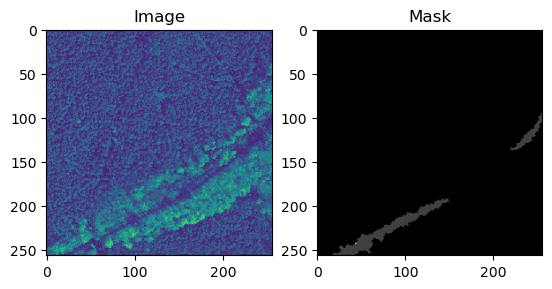

In [14]:
# get an image and mask from the batch
i = 10
image = sample['image'][i]
mask = sample['mask'][i]

# plot the image and mask
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(image[0,:,:], vmin=0, vmax=255)
ax1.set_title('Image')
ax2.imshow(mask.squeeze(), cmap='gray')
ax2.set_title('Mask')
plt.show()

Let's check how many different labels are on this sample:

In [15]:
np.unique(target[10,0,:,:])

array([ 3,  5,  8, 11])

Finally, let's perform a statistical analysis on the dataset:

In [16]:
# compute the mean and standard deviation of pixel values in the input images
image_mean = np.mean(sample['image'].numpy())
image_std = np.std(sample['image'].numpy())

print(f'Image mean: {image_mean:.3f}')
print(f'Image std: {image_std:.3f}')

# compute the frequency of different classes in the masks
classes, counts = np.unique(sample['mask'].numpy(), return_counts=True)

for i, class_name in enumerate(classes):
    print(f'Class {class_name}: {counts[i]} samples')


Image mean: 84.245
Image std: 62.472
Class 1: 4631 samples
Class 3: 444083 samples
Class 4: 1214 samples
Class 5: 326112 samples
Class 6: 222 samples
Class 7: 1868 samples
Class 8: 4491 samples
Class 9: 2729 samples
Class 10: 505 samples
Class 11: 311 samples
Class 12: 266 samples
